# Follow Along In Class

In [7]:
#!pip install torch torchvision
import torch
from torch import nn
from torch import optim                             # used to compute the derivative
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

from IPython.display import Markdown

In [8]:
torch.manual_seed(0)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = datasets.CIFAR10(root = '~/Downloads/VisionCNN/',train=True, download=True, transform=transform)

testset = datasets.CIFAR10(root = '~/Downloads/VisionCNN/',train=False, download=True, transform=transform)

batchsize = 64
train_dataloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -

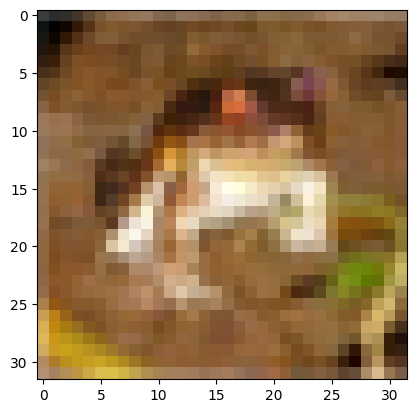

In [15]:
print(trainset[0])                  # returns X (image) and y (label)
print(trainset.classes)             # shows the classes
print(trainset[0][1])               # returns the class as a number
print(trainset[0][0])               # returns the image
print(trainset[0][0].shape)         # shape of the image

# toPILImage allows us to transform from the tensor format (3 x 32 x 32) to the plot format (32 x 32 x 3)
transform_back = transforms.Compose([transforms.Normalize((-1.,-1.,-1.),(2.,2.,2.)), transforms.ToPILImage()])
plt.imshow(transform_back(trainset[0][0]))

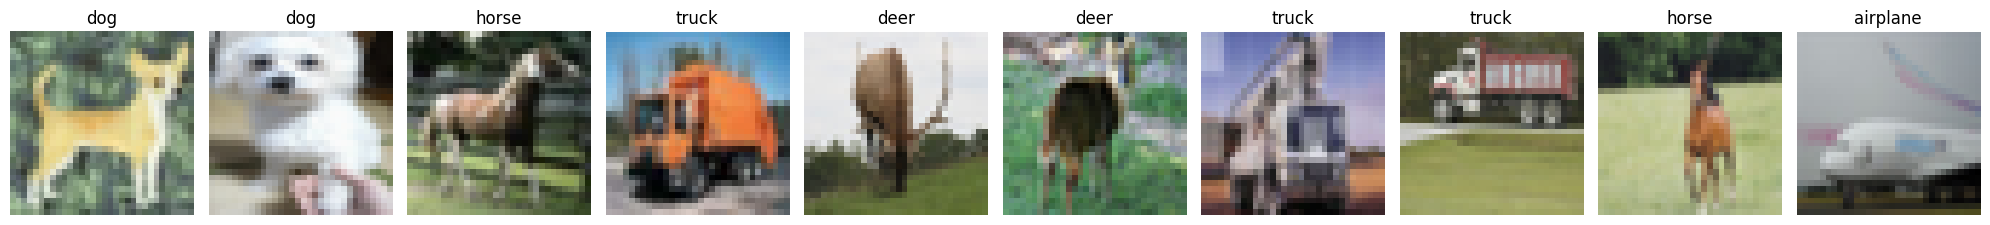

In [16]:
images, labels = next(iter(train_dataloader))

idx_to_class = {value: key for key, value in trainset.class_to_idx.items()}

plt.figure(figsize = (20, 30))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[labels[i].item()])

plt.tight_layout()
plt.show()


In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1), # output: 4x32x32
            nn.ReLU(),

            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1), # output: 8X32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # output: 8x8x8

            nn.Flatten(),
            nn.Linear(8*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

In [18]:
model = MyModel()
model.to(device)
print(model)

MyModel(
  (network): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
    (9): LogSoftmax(dim=1)
  )
)


In [21]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
train_history = []
val_history = []

In [22]:
# Training loop
model.train() # tell the model that your are trainin the model
for epoch in range(10):
    train_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # validation
    with torch.no_grad():
        val_loss = 0
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch}], train loss: {train_loss/len(trainset)}, val loss: {val_loss/len(testset)}')
    train_history += [train_loss/len(trainset)]
    val_history += [val_loss/len(testset)]
print("Finished Training")

Epoch [0], train loss: 0.025514044334888457, val loss: 0.021892218065261843
Epoch [1], train loss: 0.02087952301621437, val loss: 0.019904010623693465
Epoch [2], train loss: 0.018890657135248186, val loss: 0.01855779764652252
Epoch [3], train loss: 0.017687445439100266, val loss: 0.017853018206357957
Epoch [4], train loss: 0.016805856792926788, val loss: 0.01719098066687584
Epoch [5], train loss: 0.016078218334913255, val loss: 0.016794042026996612
Epoch [6], train loss: 0.015468174427747726, val loss: 0.016660767793655395
Epoch [7], train loss: 0.014905305104255676, val loss: 0.016548901879787446
Epoch [8], train loss: 0.014397968262434006, val loss: 0.01620245816707611
Epoch [9], train loss: 0.013977657798528671, val loss: 0.016026891577243806
Finished Training


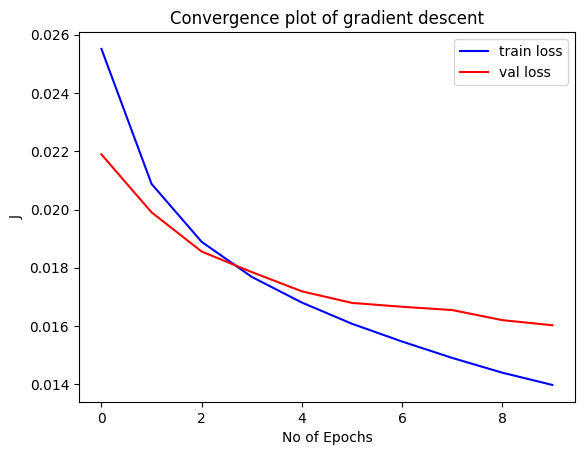

In [23]:
from matplotlib import pyplot as plt
plt.plot(train_history, 'b', label = 'train loss')
plt.plot(val_history, 'r', label = 'val loss')
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend()
plt.show()

Actual automobile	Predicted: automobile
Actual cat	Predicted: cat
Actual truck	Predicted: truck
Actual dog	Predicted: airplane
Actual horse	Predicted: horse
Actual automobile	Predicted: automobile
Actual horse	Predicted: horse
Actual automobile	Predicted: automobile
Actual cat	Predicted: cat
Actual dog	Predicted: cat


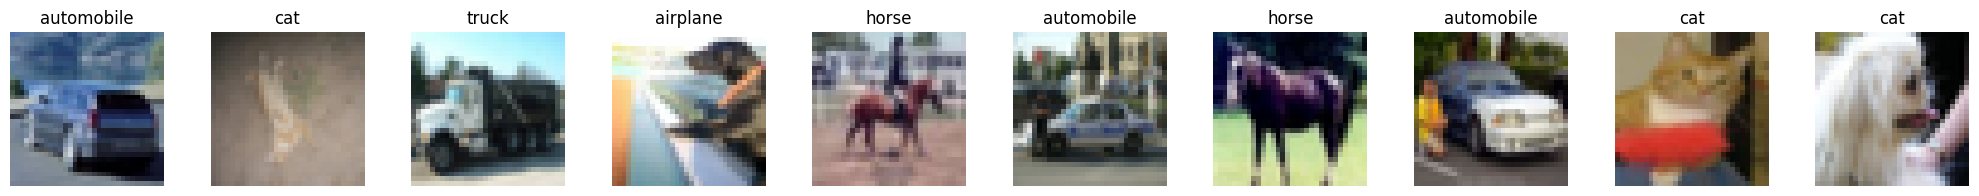

In [24]:
import torchvision

images, labels = next(iter(test_dataloader))
images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f"Actual {idx_to_class[labels[i].item()]}\tPredicted: {idx_to_class[predicted[i].item()]}")
plt.show()



In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %%')


Accuracy of the network on the 10000 test images: 64.16 %%


# In Class Assignment


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MyCnnModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(128*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        return self.network(x)

In [10]:
model_cnn = MyCnnModel()
model_cnn.to(device)
print(model_cnn)

MyCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=2048, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=

In [11]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr = 0.001)
train_history = []
val_history = []

In [12]:
# Training loop
model_cnn.train() # tell the model_cnn that your are trainin the model_cnn
for epoch in range(10):
    train_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(inputs)

        loss = criteria(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    # validation
    with torch.no_grad():
        val_loss = 0
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_cnn(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()

    print(f'Epoch [{epoch}], train loss: {train_loss/len(trainset)}, val loss: {val_loss/len(testset)}')
    train_history += [train_loss/len(trainset)]
    val_history += [val_loss/len(testset)]
print("Finished Training")

Epoch [0], train loss: 0.024044698144197463, val loss: 0.018362365919351576
Epoch [1], train loss: 0.01525123547077179, val loss: 0.013432875055074692
Epoch [2], train loss: 0.011395085614323616, val loss: 0.01115421720445156
Epoch [3], train loss: 0.008888443233966828, val loss: 0.010483354085683823
Epoch [4], train loss: 0.007024823967814445, val loss: 0.010443071326613425
Epoch [5], train loss: 0.0054904226490855215, val loss: 0.010950541198253632
Epoch [6], train loss: 0.004258680892437697, val loss: 0.012729668363928795
Epoch [7], train loss: 0.003428415475487709, val loss: 0.012765269693732262
Epoch [8], train loss: 0.0028696268578618763, val loss: 0.013360665959119796
Epoch [9], train loss: 0.002390574361719191, val loss: 0.0147895461499691
Finished Training


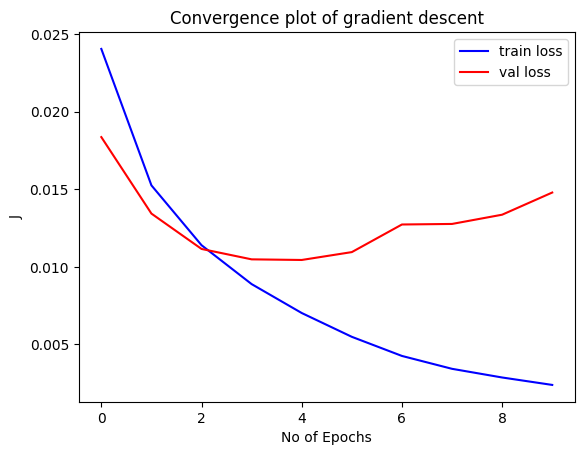

In [13]:
from matplotlib import pyplot as plt
plt.plot(train_history, 'b', label = 'train loss')
plt.plot(val_history, 'r', label = 'val loss')
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend()
plt.show()

Actual horse	Predicted: cat
Actual automobile	Predicted: automobile
Actual frog	Predicted: frog
Actual horse	Predicted: horse
Actual bird	Predicted: bird
Actual ship	Predicted: ship
Actual bird	Predicted: frog
Actual truck	Predicted: truck
Actual bird	Predicted: bird
Actual bird	Predicted: bird


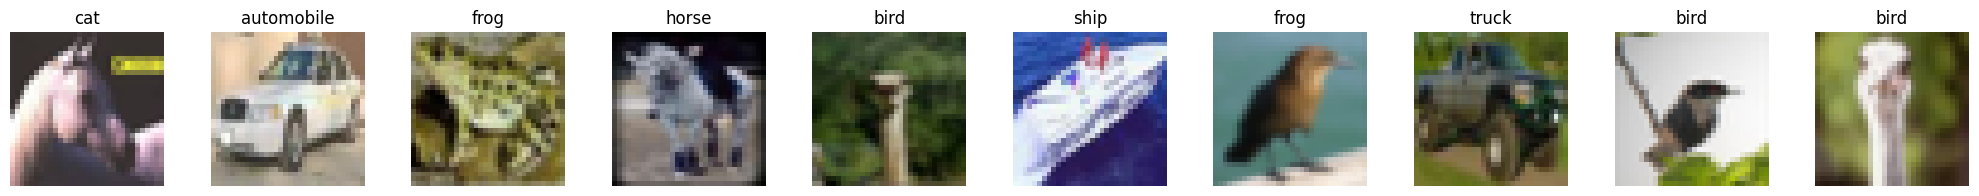

In [19]:
import torchvision

images, labels = next(iter(test_dataloader))
images = images.to(device)
labels = labels.to(device)

outputs = model_cnn(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f"Actual {idx_to_class[labels[i].item()]}\tPredicted: {idx_to_class[predicted[i].item()]}")
plt.show()



In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %%')


Accuracy of the network on the 10000 test images: 78.72 %%
